In [ ]:
'''
Name: model-development.(ipynb/py)
Description: Notebook for continuous model development, tweaking, and testing
Authors: Landen Doty, Sepehr Noori
Date: 10/22/23
'''

# Import Packages

In [27]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Import Data from Drive

In [28]:
import os
import zipfile
# mounting local google drive
from google.colab import drive
drive.mount('/content/drive')

# copying local drive data to colab
!mkdir /tmp/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/tmp/data’: File exists


# Binary Cars

In [29]:
# Unzip and store data on colab instance
!cp "/content/drive/MyDrive/Colab Notebooks/ParkSense/vehicle_detection_data.zip" "/tmp/data/"
zip_file = '/tmp/data/vehicle_detection_data.zip'
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall('/tmp/data/vehicle_data')
zip_ref.close()


In [30]:
# path to datasets
vehicle = '/tmp/data/vehicle_data/data/vehicles/'
non_vehicle = '/tmp/data/vehicle_data/data/non-vehicles/'


# Split Dataset into training and validation

In [ ]:
! bash /content/drive/MyDrive/Colab\ Notebooks/ParkSense/setup-data.sh

In [32]:
! rm -r /tmp/data/vehicle_data/data/vehicles
! rm -r /tmp/data/vehicle_data/data/non-vehicles/

# Data Generators

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create training and validation data generators
# Currently normalizes images, but commented lines can be used for image augmentation if our model requires re-training with more creative datasets

# validation split allows us to use 25% of the specified dir. for training
train_datagen = ImageDataGenerator(
      rescale=1./255,
      validation_split=.75
      #rotation_range=40,
      #width_shift_range=0.2,
      #height_shift_range=0.2,
      #shear_range=0.2,
      #zoom_range=0.2,
      #horizontal_flip=True,
      #fill_mode='nearest'
      )

# validation split allows us to use 25% of the specified dir. for validation
validation_datagen = ImageDataGenerator(
      rescale=1./255,
      validation_split=.25
      #rotation_range=40,
      #width_shift_range=0.2,
      #height_shift_range=0.2,
      #shear_range=0.2,
      #zoom_range=0.2,
      #horizontal_flip=True,
      #fill_mode='nearest'
      )

# generate images from our extracted data set
# VGG16 used 150x150x3 input image size

# ResNet50

# training images
train_generator = train_datagen.flow_from_directory(
        '/tmp/data/vehicle_data/data/training/',
        target_size=(64, 48),
        batch_size=32,
        subset='training',
        class_mode='binary')

# validation images
validation_generator = validation_datagen.flow_from_directory(
        '/tmp/data/vehicle_data/data/test/',
        target_size=(64, 48),
        batch_size=32,
        subset='validation',
        class_mode='binary')

Found 2220 images belonging to 2 classes.
Found 2220 images belonging to 2 classes.


In [49]:
! ls /tmp/data/vehicle_data/data/test/non-vehicles/ | wc -l
! ls /tmp/data/vehicle_data/data/test/vehicles/ | wc -l

4484
4396


# Define and Train Model

In [34]:
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras.applications import ResNet50

IMAGE_SHAPE = (64,48)

#Using ResNet50 as our base model
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=IMAGE_SHAPE+(3,))
base_model.trainable = False


model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              metrics=['acc'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_7 (Dense)             (None, 10)                81930     
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 23669653 (90.29 MB)
Trainable params: 81941 (320.08 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [39]:
history = model.fit(
      train_generator,
      epochs=10,
      validation_data=validation_generator)

Epoch 1/10
70/70 [==============================] - 68s 979ms/step - loss: 0.3121 - acc: 0.8802 - val_loss: 0.2901 - val_acc: 0.8820
Epoch 2/10
70/70 [==============================] - 52s 743ms/step - loss: 0.3007 - acc: 0.8829 - val_loss: 0.2754 - val_acc: 0.8919
Epoch 3/10
70/70 [==============================] - 69s 991ms/step - loss: 0.2891 - acc: 0.8824 - val_loss: 0.2570 - val_acc: 0.9050
Epoch 4/10
70/70 [==============================] - 68s 976ms/step - loss: 0.2812 - acc: 0.8856 - val_loss: 0.2495 - val_acc: 0.9059
Epoch 5/10
70/70 [==============================] - 67s 960ms/step - loss: 0.2748 - acc: 0.8874 - val_loss: 0.2419 - val_acc: 0.9090
Epoch 6/10
70/70 [==============================] - 69s 996ms/step - loss: 0.2685 - acc: 0.8923 - val_loss: 0.2359 - val_acc: 0.9077
Epoch 7/10
70/70 [==============================] - 68s 982ms/step - loss: 0.2624 - acc: 0.8982 - val_loss: 0.2324 - val_acc: 0.9095
Epoch 8/10
70/70 [==============================] - 52s 753ms/step - 

##Save model


In [40]:
resnet50_saved_model = "/content/drive/MyDrive/Colab Notebooks/ParkSense/models/resnet50_saved_model"
tf.saved_model.save(model,resnet50_saved_model)

## Training Accuracy

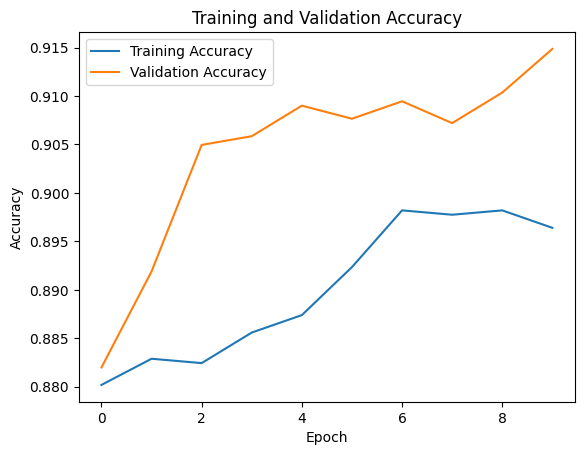

In [41]:
import matplotlib.pyplot as plt

history = model.history
# Get the training and validation accuracy from the history object
train_accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']

# Plot the training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')

# Set the title and labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Show the plot
plt.legend()
plt.show()

## Testing


In [63]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

test_datagen = ImageDataGenerator(
      rescale=1./255,
      validation_split=.1
      #rotation_range=40,
      #width_shift_range=0.2,
      #height_shift_range=0.2,
      #shear_range=0.2,
      #zoom_range=0.2,
      #horizontal_flip=True,
      #fill_mode='nearest'
      )

test_generator = test_datagen.flow_from_directory(
        '/tmp/data/vehicle_data/data/test/',
        target_size=(64, 48),
        batch_size=32,
        subset='validation',
        class_mode='binary')

test_images=np.concatenate([test_generator.next()[0] for i in range(test_generator.__len__())])
test_labels=np.concatenate([test_generator.next()[1] for i in range(test_generator.__len__())])
print(test_images.shape)
print(test_labels.shape)

Found 887 images belonging to 2 classes.
(887, 64, 48, 3)
(887,)


In [64]:
import math

predictions = model.predict_on_batch(test_images)
correct = 0

for i in range(len(predictions)):
  pred = predictions[i][0]
  if pred > 0.5:
    if math.ceil(pred) == test_labels[i]:
      correct += 1
  elif math.floor(pred) == test_labels[i]:
    correct += 1

print(f"Correct predictions: {correct}")
print(f"Accuracy: {correct/len(predictions)}")

Correct predictions: 441
Accuracy: 0.4971815107102593


#Convert Model

In [68]:
#Converter quantization and optimized for size
import pathlib

converter = tf.lite.TFLiteConverter.from_saved_model(resnet50_saved_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_models_dir = pathlib.Path("/tmp/")
tflite_model = converter.convert()
tflite_model_file = tflite_models_dir/'resnet50_parksense.tflite'
tflite_model_file.write_bytes(tflite_model)

24004488